In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import scipy
from matplotlib import colors

from scipy.io.wavfile import read
from scipy.signal import spectrogram
from skimage.feature import peak_local_max
import random

In [113]:
# ----------------------------------------------------------------------------
# Create a fingerprint for an audio file based on a set of hashes
# ----------------------------------------------------------------------------


class Encoding:

    """
    Class implementing the procedure for creating a fingerprint 
    for the audio files

    The fingerprint is created through the following steps
    - compute the spectrogram of the audio signal
    - extract local maxima of the spectrogram
    - create hashes using these maxima

    """
    def __init__(self):

        """
        Class constructor

        To Do
        -----

        Initialize in the constructor all the parameters required for
        creating the signature of the audio files. These parameters include for
        instance:
        - the window selected for computing the spectrogram
        - the size of the temporal window 
        - the size of the overlap between subsequent windows
        - etc.

        All these parameters should be kept as attributes of the class.
        """
        
        self.window = 128
        self.noverlap = 32
        self.t = []
        self.f = []
        self.hashes = []

    def energie_min(self):     
          """
      This function keeps the lowest number of values of the spectrogram necessary to retain 90% of the energy of the spectrogram.
      """

          E_tot = np.sum(np.square(self.Sxx))
          print(f"l'énergie du signal est {E_tot}, le nombre de points est {np.prod(self.Sxx.shape)}")
          E = 0                                       
          i = 1
          while E < 0.90 * E_tot:             #We add the points of lowest frequency one after one until we reach 90% of the total energy.
              E = np.sum(self.Sxx[:i] ** 2)   #The energy is calculated on the whole sample duration
              i += 1
          print(f"la nouvelle énergie est {E}, soit {E/E_tot} % de la valeur initiale et le nombre de points est {np.product(self.Sxx[:i].shape)}")
  
          self.Sxx = self.Sxx[:i]     
          self.f = self.f[:i]                 #We consequently adjust the frequency axis.


    def process(self,fs,s, start = 0, duration = None, delta_t = 1, distance = 40):

        """

        To Do
        -----

        This function takes as input a sampled signal s and the sampling
        frequency fs and returns the fingerprint (the hashcodes) of the signal.
        The fingerprint is created through the following steps
        - spectrogram computation
        - local maxima extraction
        - hashes creation

        Implement all these operations in this function. Keep as attributes of
        the class the spectrogram, the range of frequencies, the anchors, the 
        list of hashes, etc.

        Each hash can conveniently be represented by a Python dictionary 
        containing the time associated to its anchor (key: "t") and a numpy 
        array with the difference in time between the anchor and the target, 
        the frequency of the anchor and the frequency of the target 
        (key: "hash")


        Parameters
        ----------

        fs: int
           sampling frequency [Hz]
        s: numpy array
           sampled signal
        start : starting time of the sample
        duration : duration of the sample 
        delta_t : highest time separating an anchor from its target
        distance : lowest distance separating two maxima in the signal's constellation
        """

        if duration != None : 
          s=s[start*fs : start*fs + duration*fs]
        else :
          s=s[start*fs :]
        self.spectr = spectrogram(s,fs,nperseg = self.window,noverlap = self.noverlap)
        self.f, self.t, self.Sxx = self.spectr
        self.t = self.t + start   #adjusting the time axis
        
        self.energie_min()
        
        self.constellation_indices = peak_local_max(self.Sxx, min_distance=distance, exclude_border = False,indices = True) #Calculating the signal's constellation
        t = self.t[self.constellation_indices[:,1]]
        f = self.f[self.constellation_indices[:,0]]
        n = len(t)
        delta_f = 500     #defining the highest frequency separating an anchor from its target.

        #creation of hashes
        self.hashes = {}
        for a in range(n):
          for i in range(a,n):
            dt = t[i] - t[a]
            if dt > 0 and dt <= delta_t and abs(f[a] - f[i]) <= delta_f:
              self.hashes[str(t[a])] = np.array([dt,f[a],f[i]])


    def display_spectrogram(self, display_anchors = True):

       """
        Displays the signal's spectrogram.

        Parameters 
        ----------
        display_anchors : if True, displays the signal's constellation.
        """

       plt.figure(figsize=(10,10))
       plt.pcolormesh(self.t,self.f,self.Sxx, norm = colors.LogNorm())
       if display_anchors :
          t = self.t[self.constellation_indices[:,1]]
          f = self.f[self.constellation_indices[:,0]]
          plt.scatter(t,f,color = 'red', marker = 'o')
    
    # On teste quelle part de l'énergie et combien de maxima restent en augmentant la distance entre les maxima
    def compare_distance(self):
      """
      Tests what proportion of the energy and how many maxima remain when increasing the distance between the elements of the constellation.
      """
      E_tot = np.sum(self.Sxx**2)
      dist_list = [1,5,10,50,100,500,1000]
      for distance in dist_list:
        mask_maxi = peak_local_max(self.Sxx, min_distance=distance, exclude_border = False, indices = False)
        constellation = self.Sxx[mask_maxi]
        E = np.sum(constellation**2)
        nb_max = np.sum(mask_maxi)
        print(f"distance : {distance}, énergie :{E/E_tot}%, nombre de maxima :{nb_max}")



l'énergie du signal est 6667240472576.0, le nombre de points est 487435
la nouvelle énergie est 6354910052352.0, soit 0.953154444694519 % de la valeur initiale et le nombre de points est 37495


c:\Users\antoi\Anaconda3\lib\site-packages\ipykernel_launcher.py:109: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


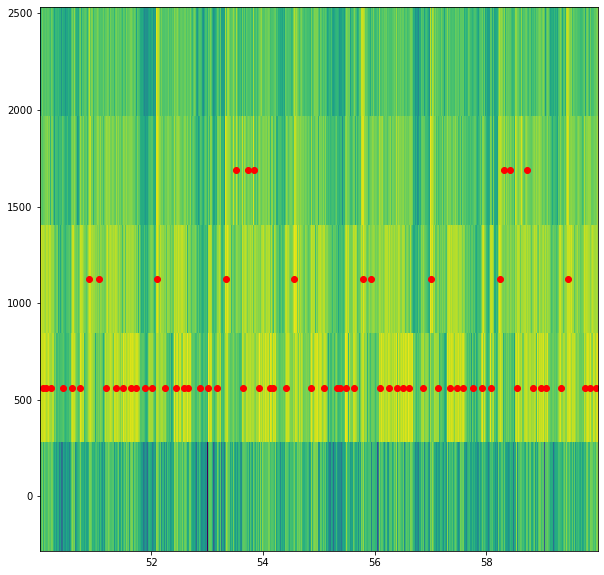

In [114]:
# ----------------------------------------------
# Run the script
# ----------------------------------------------
if __name__ == '__main__':

    encoder = Encoding()
    fs, s = read('samples\Cash Machine - Anno Domini Beats.wav')
    encoder.process(fs,s,start = 50, duration = 10, delta_t = 0.1)
    encoder.display_spectrogram(display_anchors=True)

In [30]:
encoder.compare_distance()

c:\Users\antoi\Anaconda3\lib\site-packages\ipykernel_launcher.py:149: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


distance : 1, énergie :0.6614364981651306%, nombre de maxima :2807
distance : 5, énergie :0.35975244641304016%, nombre de maxima :608
distance : 10, énergie :0.2529222071170807%, nombre de maxima :299
distance : 50, énergie :0.14259086549282074%, nombre de maxima :62
distance : 100, énergie :0.117792047560215%, nombre de maxima :36
distance : 500, énergie :0.04681452363729477%, nombre de maxima :7
distance : 1000, énergie :0.028969954699277878%, nombre de maxima :4


In [115]:
print(len(encoder.hashes))
encoder.hashes

4


{'59.77688888888889': array([8.000e-02, 5.625e+02, 5.625e+02]),
 '50.11822222222222': array([8.800e-02, 5.625e+02, 5.625e+02]),
 '56.510222222222225': array([9.86666667e-02, 5.62500000e+02, 5.62500000e+02]),
 '55.31955555555555': array([6.800e-02, 5.625e+02, 5.625e+02])}

In [105]:
"""
Create a database containing the hashcodes of the songs stored 
in the specified folder (.wav files only). 
The database is saved as a pickle file as a list of dictionaries.
Each dictionary has two keys 'song' and 'hashcodes', corresponding 
to the name of the song and to the hashcodes used as signature for 
the matching algorithm.
"""

from concurrent.futures import process
import numpy as np
import matplotlib.pyplot as plt

from scipy.io.wavfile import read
# from algorithm import *


# ----------------------------------------------
# Run the script
# ----------------------------------------------
if __name__ == '__main__':

    folder = './samples/'

    # 1: Load the audio files
    import os
    audiofiles = os.listdir(folder)
    audiofiles = [item for item in audiofiles if item[-4:] =='.wav']

    # 2: Set the parameters of the encoder
    # Insert your code here
    coder = Encoding()
    delta_t = 1
    distance=40
    table_fs_s = {}
    for filename in audiofiles :
        fs, s = read(f"samples/{filename}") 
        table_fs_s[filename] = [fs, s]
    start = 50 # We select an extract starting at 50s ...
    duration = 10 # ... which lasts 10s
    
    # 3: Construct the database
    database = {}
    # Insert your code here
    for key in table_fs_s:
        fs, s = table_fs_s[key]
        coder.process(fs,s,delta_t=delta_t,distance=distance)
        database[key] = (coder.hashes)

    # 4: Save the database
    with open('songs.pickle', 'wb') as handle:
        pickle.dump(database, handle, protocol=pickle.HIGHEST_PROTOCOL)



l'énergie du signal est 106077102276608.0, le nombre de points est 7047300
la nouvelle énergie est 96006737756160.0, soit 0.9050655961036682 % de la valeur initiale et le nombre de points est 433680


c:\Users\antoi\Anaconda3\lib\site-packages\ipykernel_launcher.py:109: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


l'énergie du signal est 603253047296.0, le nombre de points est 8776690
la nouvelle énergie est 578448982016.0, soit 0.9588828086853027 % de la valeur initiale et le nombre de points est 405078
l'énergie du signal est 280463243476992.0, le nombre de points est 10774790
la nouvelle énergie est 274322782420992.0, soit 0.9781060218811035 % de la valeur initiale et le nombre de points est 663064
l'énergie du signal est 54121965027328.0, le nombre de points est 7909460
la nouvelle énergie est 51523321069568.0, soit 0.9519854187965393 % de la valeur initiale et le nombre de points est 365052
l'énergie du signal est 1124589895680.0, le nombre de points est 8072480
la nouvelle énergie est 1045521170432.0, soit 0.9296910762786865 % de la valeur initiale et le nombre de points est 620960
l'énergie du signal est 130549356167168.0, le nombre de points est 7750275
la nouvelle énergie est 122977421099008.0, soit 0.9419994354248047 % de la valeur initiale et le nombre de points est 476940
l'énergie d

In [106]:
# ----------------------------------------------------------------------------
# Compares two set of hashes in order to determine if two audio files match
# ----------------------------------------------------------------------------

class Matching:

    """
    Compare the hashes from two audio files to determine if these
    files match

    Attributes
    ----------

    hashes1: list of dictionaries
       hashes extracted as fingerprints for the first audiofile. Each hash 
       is represented by a dictionary containing the time associated to
       its anchor (key: "t") and a numpy array with the difference in time
       between the anchor and the target, the frequency of the anchor and
       the frequency of the target (key: "hash")

    hashes2: list of dictionaries
       hashes extracted as fingerprint for the second audiofile. Each hash 
       is represented by a dictionary containing the time associated to
       its anchor (key: "t") and a numpy array with the difference in time
       between the anchor and the target, the frequency of the anchor and
       the frequency of the target (key: "hash")

    matching: numpy array
       absolute times of the hashes that match together

    offset: numpy array
       time offsets between the matches
    """

    def __init__(self, hashes1, hashes2):

        """
        Class constructor

        Compare the hashes from two audio files to determine if these
        files match

        To Do
        -----

        Implement a code establishing correspondences between the hashes of
        both files. Once the correspondences computed, construct the 
        histogram of the offsets between hashes. Finally, search for a criterion
        based on the histogram that allows to determine if both audio files 
        match

        Parameters
        ----------

        hashes1: list of dictionaries
           hashes extracted as fingerprint for the first audiofile. Each hash 
           is represented by a dictionary containing the time associated to
           its anchor (key: "t") and a numpy array with the difference in time
           between the anchor and the target, the frequency of the anchor and
           the frequency of the target

        hashes2: list of dictionaries
           hashes extracted as fingerprint for the second audiofile. Each hash 
           is represented by a dictionary containing the time associated to
           its anchor (key: "t") and a numpy array with the difference in time
           between the anchor and the target, the frequency of the anchor and
           the frequency of the target
        """


        self.hashes1 = hashes1
        self.hashes2 = hashes2

             
    def display_scatterplot(self):
       """
        Display through a scatterplot the times associated to the hashes
        that match
        """
       key1 = self.hashes1.keys()
       key2 = self.hashes2.keys()
       time_cloud = [[],[]]
       for k1 in key1:
           for k2 in key2:
              if not (self.hashes1[k1] - self.hashes2[k2]).sum(): #The times "ta" of both hashes are displayed only if their associated values are equal
                 time_cloud[0].append(float(k1))
                 time_cloud[1].append(float(k2))
       plt.scatter(time_cloud[0],time_cloud[1])
       plt.plot(np.linspace(max([min(time_cloud[0]),min(time_cloud[1])]),min([max(time_cloud[0]),max(time_cloud[1])]),100),np.linspace(max([min(time_cloud[0]),min(time_cloud[1])]),min([max(time_cloud[0]),max(time_cloud[1])]),100),c='r')
       plt.show()
       return time_cloud


    def display_histogram(self):

        """
        Display the offset histogram
        """
        time_cloud = np.array(self.display_scatterplot())
        diff = time_cloud[1] - time_cloud[0]
        plt.hist(diff,density=True)
        plt.show()

In [117]:
s,fs = read("samples\Cash Machine - Anno Domini Beats.wav")
s2, fs2 = s,fs
dt = 1
encoder2 = Encoding()
encoder2.process(s,fs,start=50,duration=10,delta_t=dt)
hashes_1 = encoder2.hashes

encoder2.process(s2,fs2,start=50,duration=10,delta_t=dt)
hashes_2 = encoder2.hashes

l'énergie du signal est 6667240472576.0, le nombre de points est 487435
la nouvelle énergie est 6354910052352.0, soit 0.953154444694519 % de la valeur initiale et le nombre de points est 37495
l'énergie du signal est 6667240472576.0, le nombre de points est 487435
la nouvelle énergie est 6354910052352.0, soit 0.953154444694519 % de la valeur initiale et le nombre de points est 37495


c:\Users\antoi\Anaconda3\lib\site-packages\ipykernel_launcher.py:109: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


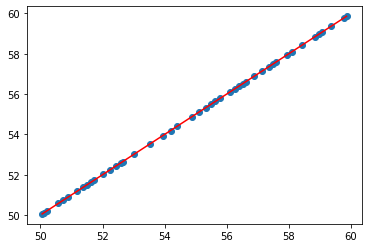

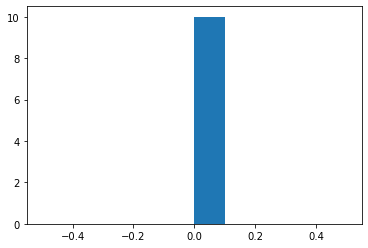

In [118]:
match = Matching(hashes_1, hashes_2)
match.display_histogram()

In [109]:
s,fs = read("samples\Cash Machine - Anno Domini Beats.wav")
s2, fs2 = read("samples\Cash Machine - Anno Domini Beats.wav")

encoder2 = Encoding()
encoder2.process(s,fs,distance = distance,delta_t=delta_t)
hashes_1 = encoder2.hashes

encoder2.process(s2,fs2,start=50,duration=10,distance = distance,delta_t=delta_t)
hashes_2 = encoder2.hashes

l'énergie du signal est 106077102276608.0, le nombre de points est 7047300
la nouvelle énergie est 96006737756160.0, soit 0.9050655961036682 % de la valeur initiale et le nombre de points est 433680


c:\Users\antoi\Anaconda3\lib\site-packages\ipykernel_launcher.py:109: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


l'énergie du signal est 6667240472576.0, le nombre de points est 487435
la nouvelle énergie est 6354910052352.0, soit 0.953154444694519 % de la valeur initiale et le nombre de points est 37495


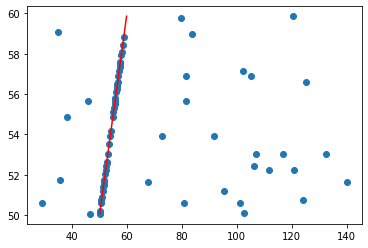

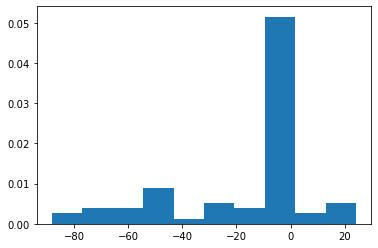

In [110]:
match = Matching(hashes_1, hashes_2)
match.display_histogram()

Selected song: Frisk - Au.Ra
l'énergie du signal est 11328606437376.0, le nombre de points est 487435
la nouvelle énergie est 10778499350528.0, soit 0.9514408707618713 % de la valeur initiale et le nombre de points est 29996


c:\Users\antoi\Anaconda3\lib\site-packages\ipykernel_launcher.py:109: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


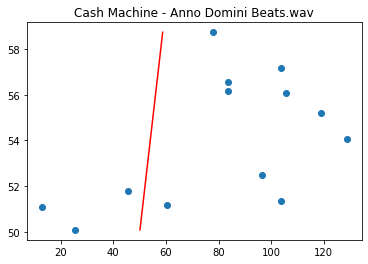

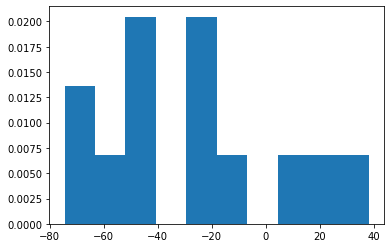

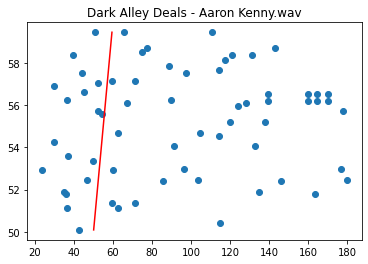

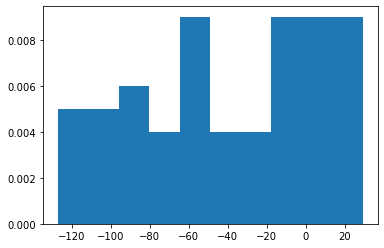

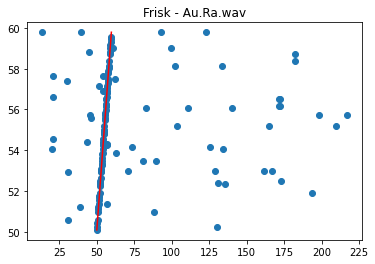

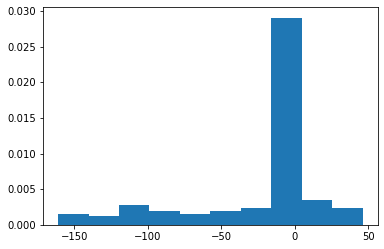

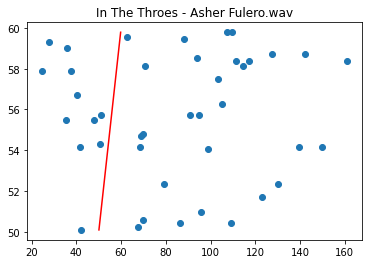

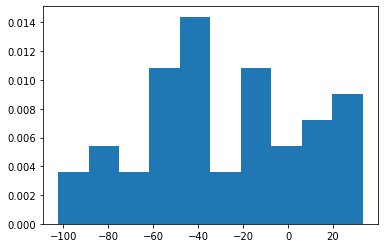

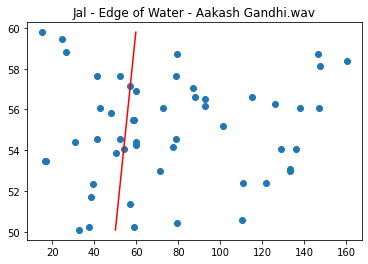

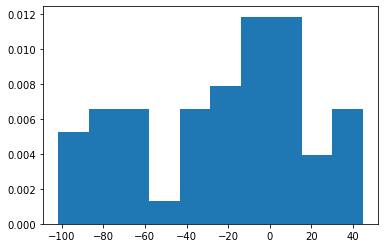

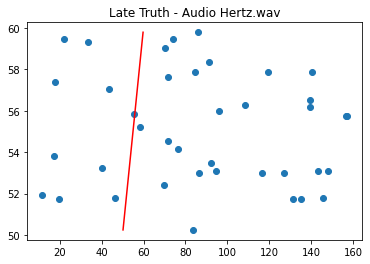

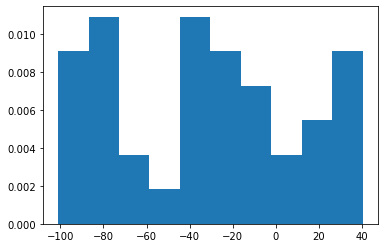

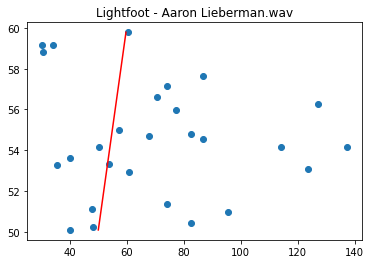

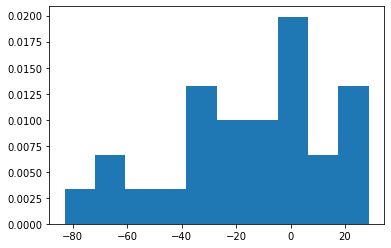

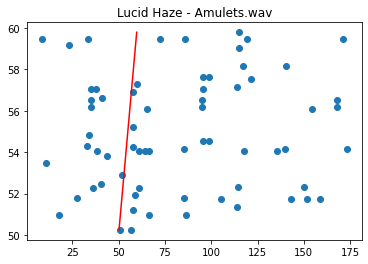

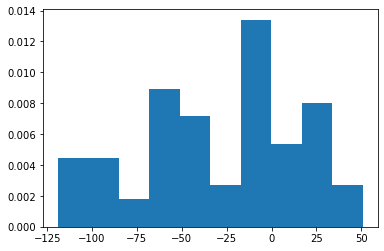

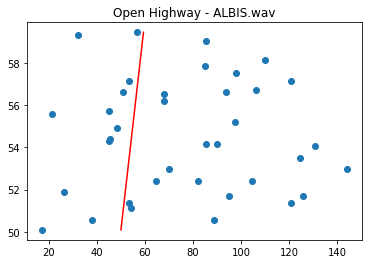

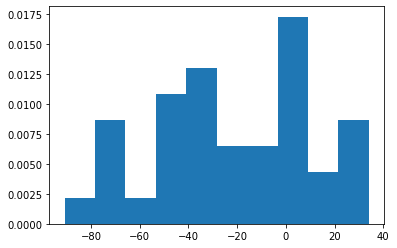

In [112]:
# 1: Load the database
with open('songs.pickle', 'rb') as handle:
    database = pickle.load(handle)

# 2: Create an instance of the class Encoder
encoder = Encoding()

# 3: Randomly get an extract from one of the songs of the database
songs = [item for item in os.listdir('./samples') if item[:-4] != '.wav']
song = random.choice(songs)
print('Selected song: ' + song[:-4])
filename = './samples/' + song

fs, s = read(filename)
start = 50 # We select an extract starting at 50s ...
duration = 10 # ... which lasts 10s
delta_t = 1

# 4: Use the encoder to extract a fingerprint of the sample
encoder.process(fs, s, start=start, duration=duration,distance=distance,delta_t=delta_t)
hashes = encoder.hashes

# 5: Using the class Matching, compare the fingerprint to all the 
# fingerprints in the database
for key, hash in database.items() :
    match = Matching(hash, hashes)
    plt.title(key)
    match.display_histogram()
    

# Insert code here